# 3 columns plot [Fractional Area, Accuracy and Distance to LIPs] with GyPSuMS

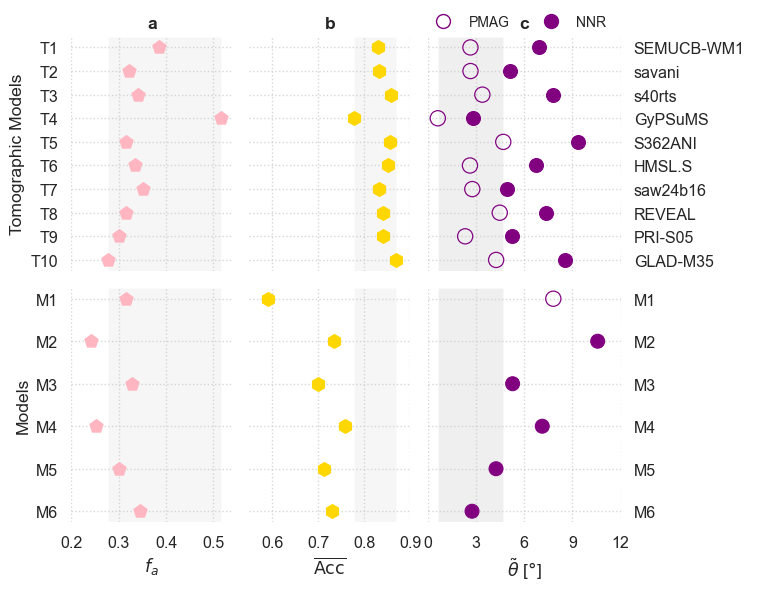

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import warnings
from matplotlib.lines import Line2D
import pandas as pd

cm =1/2.54
warnings.filterwarnings('ignore')

sns.set(font_scale=1.05, style='white')

fig, axes = plt.subplots(2,3, figsize= (18*cm,16*cm), gridspec_kw={'width_ratios': [1, 1, 1.2]}, sharey='row', sharex='col' ) #layout='constrained')

kwargs ={'vmin':0.25, 'vmax':0.6}

models= ['gld421', 'gld428','gld431','gld434','gld486','gld504']
model_labels =['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
tomo_labels =['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']
xlabels =['$f_{a}$',r'$\overline{\mathrm{Acc}}$', r'$\tilde{\theta}$ [$\degree$]','$f_{a}$',r'$\overline{\mathrm{Acc}}$', r'$\tilde{\theta}$ [$\degree$]',]
Tomographic_names =['SEMUCB-WM1','savani','s40rts','GyPSuMS','S362ANI','HMSL.S','saw24b16','REVEAL','PRI-S05','GLAD-M35']

hfont = {'fontname':'DejaVu Sans','fontsize':6,}

#---------------------------------------------------------LOAD AND PROCESS DATASETs-----------------------------------------------------#

#----------------------------------------------------------1. FRACTIONAL AREA ----------------------------------------------#
fractional_area_fpath = glob.glob('.././UOW-*_Earth/area/*csv')
frac_data = pd.read_csv(fractional_area_fpath[0]).rename({'Unnamed: 0':'Models'}, axis=1)
#print(frac_data[frac_data.Models=='GypsumS'])

# split data for mantle convection models and tomographic models
frac_data_models = frac_data[frac_data['Models'].isin(models)]
frac_data_tomo = frac_data[~frac_data['Models'].isin(models)].rename({'Models':'Tomographic Models'}, axis=1)
#print(frac_data_tomo)


#---------------------------2. ACCURACY-------------------------------------------------#
accuracy_data_fpath =glob.glob('.././UOW-*_Earth/accuracy*/*csv')
accuracy_data = (
    pd.read_csv(accuracy_data_fpath[0], header=[0, 1])             # two-header CSV
      .rename({'Unnamed: 0_level_1': 'Models'}, axis=1)            # rename level 1
      [['Unnamed: 0_level_0', 'Accuracy']]                         # select relevant top-level
      .droplevel(level=0, axis=1)                                  # drop top-level
)


# drop gypsum from row and column if exist

# column_to_drop = accuracy_data.columns[accuracy_data.columns.str.contains("gypsum", case=False, na=False)]
# accuracy_data = accuracy_data.drop( columns=column_to_drop)
# # drop row if df contains gypsum 
# accuracy_data = accuracy_data[accuracy_data['Models']!='GyPSuMS']

# split accuracy dataframe  for mantle convection models and tomographic models
filtered=accuracy_data[accuracy_data['Models'].isin(models)] # subsets accuracy dataframe for mantle convection models across all tomographic models
acc_data_models = (
    filtered
    .select_dtypes(exclude='number')                          # to retain Model column or any categorical model
    .assign(mean_accuracy= 
            filtered.select_dtypes(include='number')
            .mean(axis=1))                                     #compute means across columns
)
#print('Convection Models Accuracy:',acc_data_models.head())

#compute average performance of each tomographic models against other tomographic models excluding self
tomo_filtered = accuracy_data[~accuracy_data['Models'].isin(models)].rename({'Models':'Tomographic Models'}, axis=1)
#tomo_filtered = tomo_filtered[tomo_filtered['Tomographic Models']!='GyPSuMS']
acc_data_tomo =(
    tomo_filtered
        .select_dtypes(exclude='number')                                     #retains the tomographic models' column
        .assign(mean_accuracy= tomo_filtered 
              .select_dtypes(include='number')                               # only selects numeric columns
              .mask(np.eye(len(tomo_filtered), dtype=bool)).mean(axis=1))    # assigns np.nan to self comparisons accuracy (1) values and computes mean
    )
#print('Tomographic Accuracy:',acc_data_tomo)


#--------------------------------3. ERUPTIONS TO BLOBS-MANTLE CONVECTION MODELS-------------------------------------#
eruption_blob_paths= glob.glob('.././UOW-*_Earth/eruptions*BLOBS/*320*.csv')
#print(eruption_blob_paths)

eruption_blob_320Ma = (
    pd.read_csv(eruption_blob_paths[0], header=[0,1,2], index_col=0)          # read file and assign first 3 rows as header
    .filter(regex='Solid|-two-sided')                                         # select only solid columns or one sided test stats
    .droplevel(level=[0,-1], axis=1)                                          # drop first and last header rows
    .rename_axis('Models')
    .reset_index()
)
eruption_blob_320Ma_pmag = eruption_blob_320Ma.loc[eruption_blob_320Ma['Models']=='gld421']
eruption_blob_320Ma_nnr = eruption_blob_320Ma.loc[eruption_blob_320Ma['Models'] != 'gld421']



eruption_blob_640Ma = (
    pd.read_csv(eruption_blob_paths[1], header=[0,1,2], index_col=0)          # read file and assign first 3 rows as header
    .filter(regex='Solid|-one-sided')                                         # select only solid columns or one sided test stats
    .droplevel(level=[0,-1], axis=1)                                          # drop first and last header rows
    .rename_axis('Models')
    .reset_index()
)
    
#print('Eruption Blob over 320Myr:',eruption_blob_320Ma)
#print('Eruption Blob over 640Myr:',eruption_blob_640Ma)

#-----------------------------------------DISTANCE to LLSVPs - TOMOGRAPHIC MODELS---------------------------------------------#

tomo_llsvp_paths= glob.glob('.././UOW-*_Earth/eruptions*LLSVPs/*320*_NNR*only.csv')
#print(tomo_llsvp_paths)

tomo_llsv_320Ma = (
    pd.read_csv(tomo_llsvp_paths[0], header=[0,1,2], index_col=0)          # read file and assign first 3 rows as header
    .filter(regex='Solid|-two-sided')                                         # select only solid columns or one sided test stats
    .droplevel(level=[0,-1], axis=1)                                          # drop first and last header rows
    .rename_axis('Tomographic Models')
    .reset_index()
)
tomo_llsv_320Ma_NNR =tomo_llsv_320Ma.copy()

tomo_llsvp_paths_pmag= glob.glob('.././UOW-*_Earth/eruptions*LLSVPs/*320*_PMAG*only.csv')


tomo_llsv_320Ma_pmag = (
    pd.read_csv(tomo_llsvp_paths_pmag[0], header=[0,1,2], index_col=0)          # read file and assign first 3 rows as header
    .filter(regex='Solid|-one-sided')                                         # select only solid columns or one sided test stats
    .droplevel(level=[0,-1], axis=1)                                          # drop first and last header rows
    .rename_axis('Tomographic Models')
    .reset_index()
)

tomo_llsv_320Ma_pmag=tomo_llsv_320Ma_pmag.copy() 

# tomo_llsv_640Ma = (
#     pd.read_csv(glob.glob('UOW-*_Earth/eruptions*LLSVPs/*640*_NNR*.csv')[0], header=[0,1,2], index_col=0)          # read file and assign first 3 rows as header
#     .filter(regex='Solid|-one-sided')                                         # select only solid columns or one sided test stats
#     .droplevel(level=[0,-1], axis=1)                                          # drop first and last header rows
#     .rename_axis('Tomographic Models')
#     .reset_index()
# )

#print('Eruption LLSVPs over 320Myr:',tomo_llsv_320Ma)

#------------------------------------------PREPARE LIST OF DATASETS and X and Y for scatter plots-----------------------------------------#

final_datasets_tomo = [frac_data_tomo, acc_data_tomo, [tomo_llsv_320Ma_NNR, tomo_llsv_320Ma_pmag], ]               # change order as required, tomo_llsv_320 is repeated for distance and p-value for tomographic models
final_datasets_models =[frac_data_models, acc_data_models, [eruption_blob_320Ma_nnr, eruption_blob_320Ma_pmag,], ]  # change order as required, eruption blob_320 is repeated for distance and p-value for mantle convection models


#xlabels-  both tomographic and mantle convection models share common variables
x_labels =['Present-day frac. area', 'mean_accuracy', ['Sample', 'Sample']]
facecolors =['lightpink', 'gold', ['purple', 'none'], ]
edgecolors = ['lightpink', 'gold', ['purple', 'purple'],]
markers =['p', 'h', ['o', 'o'],]
marker_sizes =[100,100, [100,120]]
x_lims =[[0.2,0.54], [0.55,0.9], [0,12]]
x_ticks =[[0.2,0.3, 0.4, 0.5], [0.6, 0.7, 0.8, 0.9], [0, 3,6,9, 12]]

column_labels =['a','b','c']

#-----------------------Generate X-tick labels from dataset-------------------------------#

hfont = {'fontname':'DejaVu Sans','fontsize':10,}

for i, ax in enumerate(axes.flatten()):

    
    #----------------------------------------------------Stat plots for Tomographic models---------------------------------------------------#
    if  i<3:                         
        ax.set_xlim(x_lims[i])
        ax.set_yticklabels(tomo_labels)
        
       
        if isinstance(x_labels[i], str):
            ax.axvspan(np.min(final_datasets_tomo[i].iloc[:,1]),np.max(final_datasets_tomo[i].iloc[:,1]), facecolor='gainsboro', alpha=0.25, zorder=0)
            sns.scatterplot(data= final_datasets_tomo[i], x=x_labels[i], y='Tomographic Models', facecolor=facecolors[i], edgecolor=edgecolors[i],marker=markers[i],s=marker_sizes[i],  ax= ax)
        else:
            
            for lbl in range(len(x_labels[i])):
                ax.axvspan(np.min(final_datasets_tomo[i][1].iloc[:,1]),np.max(final_datasets_tomo[i][1].iloc[:,1]),facecolor='gainsboro', alpha=0.25, zorder=0)
                sns.scatterplot(data= final_datasets_tomo[i][lbl], x=x_labels[i][lbl], y='Tomographic Models', edgecolor=edgecolors[i][lbl],marker=markers[i][lbl],s=marker_sizes[i][lbl], facecolor=facecolors[i][lbl], ax= ax, label=x_labels[i][lbl], legend=False)
    
           #------------ticks_handling for tomographic models' names on right handside of 3rd column------__#
            yticks_tomo = ax.get_yticks()
            ax1= axes[0,2].twinx()
            ax1.set_ylim(ax.get_ylim())
            ax1.set_yticks(yticks_tomo)
            ax1.set_yticklabels(Tomographic_names)
            ax1.set_ylabel(' ')
            #sns.scatterplot(data= final_datasets_tomo[i][lbl], x=x_labels[i][lbl], y='Tomographic Models', edgecolor=edgecolors[i][lbl],marker=markers[i][lbl],s=marker_sizes[i][lbl], facecolor=facecolors[i][lbl], ax= ax1, label=x_labels[i][lbl], legend=False)
            # Remove ticks from ax and ax1(the twinx axis)
            ax1.tick_params(axis='y', which='both',  left=False, labelleft=False, right=False, zorder=0)
            ax.tick_params(axis='y', which='both',  left=False, labelleft=False, right=False, labelright=False, zorder=0)
                        
            
    #----------------------------------------------------Stat plots for Mantle convection models---------------------------------------------------#
    else:                        
        j=i-3
        #ax.set_title(column_labels[j], loc='center', fontsize=12, fontweight='bold')
        ax.set_yticklabels(model_labels)
        ax.set_xticks(x_ticks[j])
        ax.set_xlim(x_lims[j])
        

        if isinstance(x_labels[j], str):
            ax.axvspan(np.min(final_datasets_tomo[j].iloc[:,1]),np.max(final_datasets_tomo[j].iloc[:,1]), facecolor='gainsboro', alpha=0.25, zorder=0)
            sns.scatterplot(data= final_datasets_models[j], x=x_labels[j], y='Models', facecolor=facecolors[j], edgecolor= edgecolors[j], marker=markers[j],s=marker_sizes[j],  ax= ax)
        else:
            for lbl in range(len(x_labels[j])):
                
                
                ax.axvspan(np.min(final_datasets_tomo[j][1].iloc[:,1]),np.max(final_datasets_tomo[j][1].iloc[:,1]), facecolor='gainsboro', alpha=0.25, zorder=0)
                sns.scatterplot(data= final_datasets_models[j][lbl], x=x_labels[j][lbl], y='Models', facecolor=facecolors[j][lbl], edgecolor=edgecolors[j],marker=markers[j][lbl],s=marker_sizes[j][lbl], ax= ax)
                #print('test:',final_datasets_models[j][lbl].head())

            #----------------------Place density labels on right hand side of last column for the models ---------------------------#
            y_ticks = ax.get_yticks()
            ax_m = axes[1,2].twinx()
            ax_m.set_ylim(ax.get_ylim())
            ax_m.set_yticks(y_ticks)
            # ax_m.set_yticklabels(['$\delta\\rho_{\:b}=$+0.0%','$\delta\\rho_{\:b}=$+0.5%','$\delta\\rho_{\:b}=$+1.0%',
            #         '$\delta\\rho_{\:b}=$+1.3%','$\delta\\rho_{\:b}=$+1.6%','$\delta\\rho_{\:b}=$+2.0%'
            #         ],rotation=0,**hfont)
            ax_m.set_yticklabels(model_labels)
            # Remove ticks from ax and ax1(the twinx axis)
            ax_m.tick_params(axis='y', which='both',  left=False, labelleft=False, right=False, zorder=0)
            ax.tick_params(axis='y', which='both',  left=False, labelleft=False, right=False, labelright=False, zorder=0)


[ax.set_title(column_labels[i], loc='center',  fontweight='bold') for i, ax in enumerate(axes.flatten()) if i<3]              
[ax.grid(True, linestyle=':', alpha=0.8) for ax in axes.flatten()]
[ax.set_xlabel(xlabels[i]) for i, ax in enumerate(axes.flatten()) if i>=3]

custom_legends = [Line2D([], [], marker='o', color='none', markerfacecolor=c, markeredgecolor='purple', markersize=10, label =label) for c, label in zip(['None', 'purple'], ['PMAG', 'NNR'])]

fig.legend(
    handles= custom_legends,
    
    loc='upper center',
    ncol=2,
    bbox_to_anchor=(0.755, 0.935),  # x=center, y=above top
    frameon=False,
    fontsize=10,
    #handler_map={Circle: HandlerPatch()},
)
plt.subplots_adjust(hspace=0.075, wspace=0.1)
#plt.tight_layout()   # auto-adjusts spacing
sns.despine(left=True, bottom=True)

plt.savefig('./ExtendedDataFigures/EDF1_models_tomographic_fit_statistics.png', dpi=600, bbox_inches='tight')
plt.show()



# 3 columns plot [Fractional Area, Sensitivity and Distance to LIPs]

Eruption LLSVPs over 320Myr:   Tomographic Models    Sample  Random Test  KS-stat-two-sided
0         SEMUCB-WM1  6.924844     5.966700              0.001
1             savani  5.150495     8.466369              0.000
2             s40rts  7.800795     8.847324              0.000
3            S362ANI  9.324335    12.528079              0.000
4             HMSL.S  6.734859    10.805089              0.000
5           saw24b16  4.924596     8.496862              0.000
6             REVEAL  7.366778     8.611000              0.000
7            PRI-S05  5.276593     6.144598              0.000
8           GLAD-M35  8.532308    11.586501              0.000
9            GypsumS  2.798532     4.104047              0.000
test:    Models     Sample  Random Test  KS-stat-one-sided  KS-stat-two-sided
1  gld428  10.576082    11.484133                0.0                0.0
2  gld431   5.288757     7.844832                0.0                0.0
3  gld434   7.132258    11.633140                0.0    

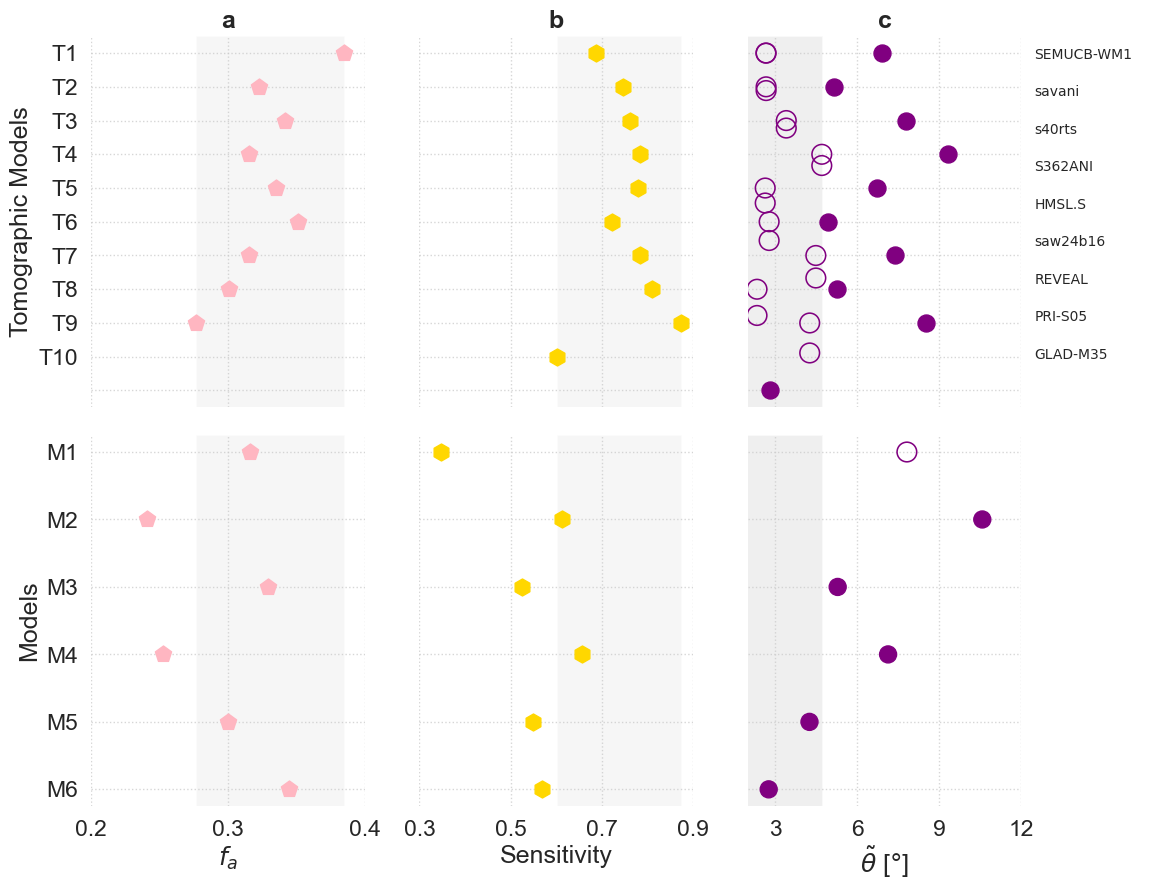

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import warnings

warnings.filterwarnings('ignore')

sns.set(font_scale=1.5, style='white')

fig, axes = plt.subplots(2,3, figsize= (12,10), gridspec_kw={'width_ratios': [1, 1, 1]}, sharey='row', sharex='col' ) #layout='constrained')

kwargs ={'vmin':0.25, 'vmax':0.6}

models= ['gld421', 'gld428','gld431','gld434','gld486','gld504']
model_labels =['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
tomo_labels =['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']
xlabels =['$f_{a}$',r'Sensitivity', r'$\tilde{\theta}$ [$\degree$]','$f_{a}$',r'Sensitivity', r'$\tilde{\theta}$ [$\degree$]']
Tomographic_names =['SEMUCB-WM1','savani','s40rts','S362ANI','HMSL.S','saw24b16','REVEAL','PRI-S05','GLAD-M35']


#---------------------------------------------------------LOAD AND PROCESS DATASETs-----------------------------------------------------#

#----------------------------------------------------------1. FRACTIONAL AREA ----------------------------------------------#
fractional_area_fpath = glob.glob('UOW-*_Earth/area/*csv')
frac_data = pd.read_csv(fractional_area_fpath[0]).rename({'Unnamed: 0':'Models'}, axis=1)
#print(frac_data[frac_data.Models=='GypsumS'])

# split data for mantle convection models and tomographic models
frac_data_models = frac_data[frac_data['Models'].isin(models)]
frac_data_tomo = frac_data[~frac_data['Models'].isin(models +['GypsumS'])].rename({'Models':'Tomographic Models'}, axis=1)


#---------------------------2. ACCURACY-------------------------------------------------#
sensitivity_data_fpath =glob.glob('UOW-*_Earth/accuracy*/*csv')
sensitivity_data =(
    pd.read_csv(sensitivity_data_fpath[0], header=[0,1])    #two header dataset
    .rename({'Unnamed: 0_level_1':'Models'}, axis=1)     # rename level 1 with models
    [['Unnamed: 0_level_0','Sensitivity']]                  # select models and accuracy from accuracy sensitivity dataset 
    .droplevel(level=0, axis=1)                          # drop top level
)

# split accuracy dataframe  for mantle convection models and tomographic models
filtered=sensitivity_data[sensitivity_data['Models'].isin(models)] # subsets accuracy dataframe for mantle convection models across all tomographic models
sensitivity_data_models = (
    filtered
    .select_dtypes(exclude='number')                          # to retain Model column or any categorical model
    .assign(mean_accuracy= 
            filtered.select_dtypes(include='number')
            .mean(axis=1))                                     #compute means across columns
)
#print('Convection Models Accuracy:',acc_data_models.head())

#compute average performance of each tomographic models against other tomographic models excluding self
tomo_filtered = sensitivity_data[~sensitivity_data['Models'].isin(models)].rename({'Models':'Tomographic Models'}, axis=1)
sensitivity_data_tomo =(
    tomo_filtered
        .select_dtypes(exclude='number')                                     #retains the tomographic models' column
        .assign(mean_accuracy= tomo_filtered 
              .select_dtypes(include='number')                               # only selects numeric columns
              .mask(np.eye(len(tomo_filtered), dtype=bool)).mean(axis=1))    # assigns np.nan to self comparisons accuracy (1) values and computes mean
    )
#print('Tomographic Accuracy:',acc_data_tomo.head())


#--------------------------------3. ERUPTIONS TO BLOBS-MANTLE CONVECTION MODELS-------------------------------------#
eruption_blob_paths= glob.glob('UOW-*_Earth/eruptions*BLOBS/*.csv')
#print(eruption_blob_paths)

eruption_blob_320Ma = (
    pd.read_csv(eruption_blob_paths[0], header=[0,1,2], index_col=0)          # read file and assign first 3 rows as header
    .filter(regex='Solid|-two-sided')                                         # select only solid columns or one sided test stats
    .droplevel(level=[0,-1], axis=1)                                          # drop first and last header rows
    .rename_axis('Models')
    .reset_index()
)
eruption_blob_320Ma_pmag = eruption_blob_320Ma.loc[eruption_blob_320Ma['Models']=='gld421']
eruption_blob_320Ma_nnr = eruption_blob_320Ma.loc[eruption_blob_320Ma['Models'] != 'gld421']



eruption_blob_640Ma = (
    pd.read_csv(eruption_blob_paths[1], header=[0,1,2], index_col=0)          # read file and assign first 3 rows as header
    .filter(regex='Solid|-one-sided')                                         # select only solid columns or one sided test stats
    .droplevel(level=[0,-1], axis=1)                                          # drop first and last header rows
    .rename_axis('Models')
    .reset_index()
)
    
#print('Eruption Blob over 320Myr:',eruption_blob_320Ma)
#print('Eruption Blob over 640Myr:',eruption_blob_640Ma)

#-----------------------------------------DISTANCE to LLSVPs - TOMOGRAPHIC MODELS---------------------------------------------#

tomo_llsvp_paths= glob.glob('UOW-*_Earth/eruptions*LLSVPs/*320*_NNR*only.csv')
#print(tomo_llsvp_paths)

tomo_llsv_320Ma = (
    pd.read_csv(tomo_llsvp_paths[0], header=[0,1,2], index_col=0)          # read file and assign first 3 rows as header
    .filter(regex='Solid|-two-sided')                                         # select only solid columns or one sided test stats
    .droplevel(level=[0,-1], axis=1)                                          # drop first and last header rows
    .rename_axis('Tomographic Models')
    .reset_index()
)

tomo_llsvp_paths_pmag= glob.glob('UOW-*_Earth/eruptions*LLSVPs/*320*_PMAG*only.csv')


tomo_llsv_320Ma_pmag = (
    pd.read_csv(tomo_llsvp_paths_pmag[0], header=[0,1,2], index_col=0)          # read file and assign first 3 rows as header
    .filter(regex='Solid|-one-sided')                                         # select only solid columns or one sided test stats
    .droplevel(level=[0,-1], axis=1)                                          # drop first and last header rows
    .rename_axis('Tomographic Models')
    .reset_index()
)

# tomo_llsv_640Ma = (
#     pd.read_csv(glob.glob('UOW-*_Earth/eruptions*LLSVPs/*640*_NNR*.csv')[0], header=[0,1,2], index_col=0)          # read file and assign first 3 rows as header
#     .filter(regex='Solid|-one-sided')                                         # select only solid columns or one sided test stats
#     .droplevel(level=[0,-1], axis=1)                                          # drop first and last header rows
#     .rename_axis('Tomographic Models')
#     .reset_index()
# )

print('Eruption LLSVPs over 320Myr:',tomo_llsv_320Ma)

#------------------------------------------PREPARE LIST OF DATASETS and X and Y for scatter plots-----------------------------------------#

final_datasets_tomo = [frac_data_tomo, sensitivity_data_tomo, [tomo_llsv_320Ma, tomo_llsv_320Ma_pmag], ]               # change order as required, tomo_llsv_320 is repeated for distance and p-value for tomographic models
final_datasets_models =[frac_data_models, sensitivity_data_models, [eruption_blob_320Ma_nnr, eruption_blob_320Ma_pmag,], ]  # change order as required, eruption blob_320 is repeated for distance and p-value for mantle convection models


#xlabels-  both tomographic and mantle convection models share common variables
x_labels =['Present-day frac. area', 'mean_accuracy', ['Sample', 'Sample']]
facecolors =['lightpink', 'gold', ['purple', 'none'], ]
edgecolors = ['lightpink', 'gold', ['purple', 'purple'],]
markers =['p', 'h', ['o', 'o'],]
marker_sizes =[150,150, [150,200]]
x_lims =[[0.2,0.4], [0.3,0.9], [2,12]]
x_ticks =[[0.2,0.3, 0.4], [0.3, 0.5, 0.7, 0.9], [3,6,9, 12]]

column_labels =['a','b','c']

#-----------------------Generate X-tick labels from dataset-------------------------------#

hfont = {'fontname':'DejaVu Sans','fontsize':10,}

for i, ax in enumerate(axes.flatten()):

    
    #----------------------------------------------------Stat plots for Tomographic models---------------------------------------------------#
    if  i<3:                         
        ax.set_xlim(x_lims[i])
        ax.set_yticklabels(tomo_labels)
        
       
        if isinstance(x_labels[i], str):
            ax.axvspan(np.min(final_datasets_tomo[i].iloc[:,1]),np.max(final_datasets_tomo[i].iloc[:,1]), facecolor='gainsboro', alpha=0.25, zorder=0)
            sns.scatterplot(data= final_datasets_tomo[i], x=x_labels[i], y='Tomographic Models', facecolor=facecolors[i], edgecolor=edgecolors[i],marker=markers[i],s=marker_sizes[i],  ax= ax)
        else:
            
            for lbl in range(len(x_labels[i])):
                ax.axvspan(np.min(final_datasets_tomo[i][1].iloc[:,1]),np.max(final_datasets_tomo[i][1].iloc[:,1]),facecolor='gainsboro', alpha=0.25, zorder=0)
                sns.scatterplot(data= final_datasets_tomo[i][lbl], x=x_labels[i][lbl], y='Tomographic Models', edgecolor=edgecolors[i][lbl],marker=markers[i][lbl],s=marker_sizes[i][lbl], facecolor=facecolors[i][lbl], ax= ax, label=x_labels[i][lbl], legend=False)
    
           #------------ticks_handling for tomographic models' names on right handside of 3rd column------__#
            ax1= axes[0,2].twinx()
            ax1.set_yticklabels(Tomographic_names, **hfont)
            ax1.set_ylabel(' ')
            sns.scatterplot(data= final_datasets_tomo[i][lbl], x=x_labels[i][lbl], y='Tomographic Models', edgecolor=edgecolors[i][lbl],marker=markers[i][lbl],s=marker_sizes[i][lbl], facecolor=facecolors[i][lbl], ax= ax1, label=x_labels[i][lbl], legend=False)
            # Remove ticks from ax and ax1(the twinx axis)
            ax1.tick_params(axis='y', which='both',  left=False, labelleft=False, right=False, zorder=0)
            ax.tick_params(axis='y', which='both',  left=False, labelleft=False, right=False, labelright=False, zorder=0)
                
            
    #----------------------------------------------------Stat plots for Mantle convection models---------------------------------------------------#
    else:                        
        j=i-3
        #ax.set_title(column_labels[j], loc='center', fontsize=12, fontweight='bold')
        ax.set_yticklabels(model_labels)
        ax.set_xticks(x_ticks[j])
        ax.set_xlim(x_lims[j])
        

        if isinstance(x_labels[j], str):
            ax.axvspan(np.min(final_datasets_tomo[j].iloc[:,1]),np.max(final_datasets_tomo[j].iloc[:,1]), facecolor='gainsboro', alpha=0.25, zorder=0)
            sns.scatterplot(data= final_datasets_models[j], x=x_labels[j], y='Models', facecolor=facecolors[j], edgecolor= edgecolors[j], marker=markers[j],s=marker_sizes[j],  ax= ax)
        else:
            for lbl in range(len(x_labels[j])):
                
                ax.axvspan(np.min(final_datasets_tomo[j][1].iloc[:,1]),np.max(final_datasets_tomo[j][1].iloc[:,1]), facecolor='gainsboro', alpha=0.25, zorder=0)
                sns.scatterplot(data= final_datasets_models[j][lbl], x=x_labels[j][lbl], y='Models', facecolor=facecolors[j][lbl], edgecolor=edgecolors[j],marker=markers[j][lbl],s=marker_sizes[j][lbl], ax= ax)
                print('test:',final_datasets_models[j][lbl].head())


         


[ax.set_title(column_labels[i], loc='center',  fontweight='bold') for i, ax in enumerate(axes.flatten()) if i<3]              
[ax.grid(True, linestyle=':', alpha=0.8) for ax in axes.flatten()]
[ax.set_xlabel(xlabels[i]) for i, ax in enumerate(axes.flatten()) if i>=3]
# fig.legend(
#     loc='upper center',
#     ncol=2,
#     bbox_to_anchor=(0.68, 0.94),  # x=center, y=above top
#     frameon=False,
#     fontsize=10
# )
plt.subplots_adjust(hspace=0.075, wspace=0.2)

sns.despine(left=True, bottom=True)
#plt.savefig('./orogens/model_tomo_statistics.png', dpi=600)
plt.show()

